Imports

In [38]:
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from collections import Counter
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_squared_error

Data import

In [39]:
df = pd.read_csv('data/processed/EDA.csv', usecols=['ID', 'INTERPRET', 'TITEL', 'processed_TITLE', 'TEXT', 'processed_TEXT','DATUM_VON', 'DATUM_BIS', 'JAHR', 'MONAT', 'DAUER','ANZ_UNIQUE_WOERTER', 'MAX_WORT_WDH', 'WORT_MAX_WDH','LAENGE_LAENGSTES_WORT', 'STOPWORD_PERCENTAGE', 'LENGTH_TITLE','SEASONAL?', 'MULTILINGAL?', 'POSITION', 'RANK_SCORE', 'MAX_RANK_SCORE','MEAN_RANK_SCORE'])
print(df.columns)

Index(['ID', 'INTERPRET', 'TITEL', 'processed_TITLE', 'TEXT', 'processed_TEXT',
       'DATUM_VON', 'DATUM_BIS', 'JAHR', 'MONAT', 'DAUER',
       'ANZ_UNIQUE_WOERTER', 'MAX_WORT_WDH', 'WORT_MAX_WDH',
       'LAENGE_LAENGSTES_WORT', 'STOPWORD_PERCENTAGE', 'LENGTH_TITLE',
       'SEASONAL?', 'MULTILINGAL?', 'POSITION', 'RANK_SCORE', 'MAX_RANK_SCORE',
       'MEAN_RANK_SCORE'],
      dtype='object')


In [40]:
print(np.shape(df))

(22762, 23)


In [41]:
def determine_top10():
    for index, row in df.iterrows():
        if np.isnan(row['TOP10']) or row['TOP10'] == False:
            df.loc[(df['ID'] == row['ID']), 'TOP10'] = row['POSITION']<=10

In [43]:
df['TOP10'] = [False for _ in range(0, 22762)]
determine_top10()
print(df)

            ID                    INTERPRET           TITEL  \
0          408                  Rumpelstilz          Kiosk    
1          408                  Rumpelstilz          Kiosk    
2          425               Costa Cordalis          Anita    
3          425               Costa Cordalis          Anita    
4          425               Costa Cordalis          Anita    
...        ...                          ...             ...   
22757  2303823            AnnenMayKantereit  3 Tage am Meer   
22758  2304169          Farid Bang & B-Case          Baller   
22759  2304914                    Yung Hurn         Alleine   
22760  2304939                  Azet & Zuna          Ohh oh   
22761  2305285  Capital Bra & Lucry & Suena           Musik   

                 processed_TITLE  \
0                      ['KIOSK']   
1                      ['KIOSK']   
2                      ['ANITA']   
3                      ['ANITA']   
4                      ['ANITA']   
...                        

In [63]:
def sum_RANK_SCORE():
    for index, row in df.iterrows():
        if np.isnan(row['SUMMED_RANK_SCORE']):
            df.loc[(df['ID'] == row['ID']), 'SUMMED_RANK_SCORE'] = sum(df.loc[(df['ID'] == row['ID']), 'RANK_SCORE'])

In [64]:
df['SUMMED_RANK_SCORE'] = np.NaN
sum_RANK_SCORE()
print(df.head())
#df.to_csv('Data/processed/EDA.csv')

    ID       INTERPRET   TITEL processed_TITLE  \
0  408     Rumpelstilz  Kiosk        ['KIOSK']   
1  408     Rumpelstilz  Kiosk        ['KIOSK']   
2  425  Costa Cordalis  Anita        ['ANITA']   
3  425  Costa Cordalis  Anita        ['ANITA']   
4  425  Costa Cordalis  Anita        ['ANITA']   

                                                TEXT  \
0  ALSO ER SAMMLE FUER EINEN GUTEN ZWECK  SAGT DE...   
1  ALSO ER SAMMLE FUER EINEN GUTEN ZWECK  SAGT DE...   
2  JVUIOUGIVTOH ICH FAND SIE IRGENDWO  ALLEIN IN ...   
3  JVUIOUGIVTOH ICH FAND SIE IRGENDWO  ALLEIN IN ...   
4  JVUIOUGIVTOH ICH FAND SIE IRGENDWO  ALLEIN IN ...   

                                      processed_TEXT   DATUM_VON   DATUM_BIS  \
0  ['ALSO', 'SAMML', 'FUER', 'GUT', 'ZWECK', 'SAG...  2009-03-06  2009-03-12   
1  ['ALSO', 'SAMML', 'FUER', 'GUT', 'ZWECK', 'SAG...  1984-10-22  1984-10-28   
2  ['JVUIOUGIVTOH', 'FAND', 'IRGENDWO', 'ALLEIN',...  2003-08-25  2003-08-31   
3  ['JVUIOUGIVTOH', 'FAND', 'IRGENDWO', 'A

df split

In [65]:
#df1 = max or mean
df = df.groupby(['ID']).first()
#df['RANK_SCORE'] = sum(df.loc[df['ID'])
#df2 = Gruppierung der Klassen in top 10 or not -> BINÄR
#print(df.head())
#df3 = Gruppierung der Klassen in 10er Klassen
#df['RANK_SCORE_10er'] = [math.trunc(pos/10) if pos !=50 else 4 for pos in df['POSITION']]
print(len(df))

3299


Train-Test Split

In [66]:
df_test = df.loc[df['JAHR'] == 2022]
df_train = df.loc[df['JAHR'] < 2022]

y_train = df_train.SUMMED_RANK_SCORE
X_train = df_train[['JAHR','ANZ_UNIQUE_WOERTER', 'MAX_WORT_WDH','LAENGE_LAENGSTES_WORT', 'STOPWORD_PERCENTAGE', 'LENGTH_TITLE','SEASONAL?']]
X_test = df_test[['JAHR','ANZ_UNIQUE_WOERTER', 'MAX_WORT_WDH', 'LAENGE_LAENGSTES_WORT', 'STOPWORD_PERCENTAGE', 'LENGTH_TITLE', 'SEASONAL?']]
y_test = df_test.SUMMED_RANK_SCORE
print(np.shape(X_train))
print(np.shape(X_test))
#from imblearn.under_sampling import RandomUnderSampler
#rus = RandomUnderSampler(random_state=0)
#X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

(3174, 7)
(125, 7)


Hyperparametertuning

In [142]:
parameter = {"booster": ["gbtree","gblinear","dart"]}

Modelling

DecisionTreeClassifier

In [58]:
clf = DecisionTreeClassifier()
#clf.fit(X_resampled, y_resampled)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.6444759206798867


In [59]:
count = Counter(y_test)
print(count)

Counter({False: 536, True: 170})


In [146]:
y_pred
y_test
count2 = Counter(y_pred)
print(count2)
mean_squared_error(y_test, y_pred)

ID
501        False
1013        True
3748       False
3843       False
4057       False
           ...  
1946371    False
1946587     True
1950168    False
2201614     True
2259587    False
Name: TOP10, Length: 125, dtype: bool

----

Random Forrest

In [56]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_resampled, y_resampled)
ypred2 = rf.predict(X_test)
print(accuracy_score(y_test, ypred2))

0.7648725212464589


In [57]:
count3 = Counter(ypred2)
count4 = Counter(y_test)
print(count3)
print(count4)

Counter({False: 636, True: 70})
Counter({False: 536, True: 170})


-----------

In [52]:
#model = RandomForestClassifier(n_estimators=100, random_state=123450, oob_score=True)
#model.fit(X_train, y_train)

#XGBOOST
model = XGBClassifier(booster='gbtree', max_depth=10, )
model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [53]:
ypred = model.predict(X_test)
print(accuracy_score(ypred, y_test))

0.726628895184136


In [55]:
count5 = Counter(ypred)
print(count5)
count6 = Counter(y_test)
print(count6)

Counter({0: 553, 1: 153})
Counter({False: 536, True: 170})


In [61]:
score = rf.score(X_train, y_train)
ypred = rf.predict(X_test)
mse = mean_squared_error(y_test, ypred)

print(score)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))
print(np.shape(ypred))
print(np.shape(y_test))
df_ = pd.DataFrame()
df_["y_test"] = y_test
df_["y_pred"] = ypred
print(df_.head())

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [85]:
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
mse = mean_squared_error(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(f'Mean Squared Error: {mse:.13}')

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [17]:
scaler = MinMaxScaler()
data = [[index, ypred[index]] for index in range(1,len(ypred))]
print(scaler.fit(data))
print(scaler.data_max_)
print(scaler.transform(data))

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train)

MinMaxScaler()
[705.  49.]
[[0.         0.52083333]
 [0.00142045 0.52083333]
 [0.00284091 0.52083333]
 ...
 [0.99715909 0.95833333]
 [0.99857955 0.64583333]
 [1.         0.14583333]]


In [63]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=df.RANK_SCORE, index=df.RANK_SCORE)
sns.heatmap(cm, annot=True)

ValueError: Shape of passed values is (50, 50), indices imply (22762, 22762)

In [ ]:
df.RANK_SCORE

----

Regression

ValueError: x and y must be the same size

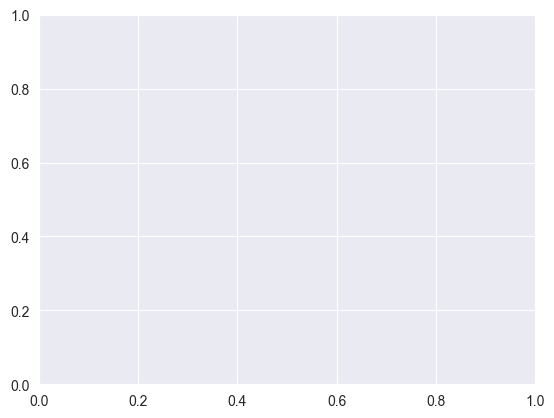

In [71]:
from sklearn.tree import DecisionTreeRegressor
reg =DecisionTreeRegressor()
reg.fit(X_train, y_train)
reg.score(X_test,y_test)
ypred = reg.predict(X_test)

plt.figure()
plt.scatter(X_train, y_train, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, ypred, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()